# Plot conductivity data

In [75]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
sys.path.insert(1,'..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import ternary
import helpers.fileload as fl
from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.plotting import quat_slice_scatter, scatter_slices, quat_slice_heatmap2, add_colorbar, \
    sliceformula_from_tuple, rescale_ticks, heatmap_inputs, dict_lookup, log_dict_lookup
from helpers.pickletools import pickle_dict
from citrination_client import CitrinationClient
from ternary.helpers import simplex_iterator
import pymatgen as mg

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/conductivity') #data/EIS_data
pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/conductivity/plots')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

In [3]:
data = pd.DataFrame()

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':'dry'})
    fl.get_formula(df,overwrite=True)
    df['sample'] = sample
    df.index = df.index + sample
    data = data.append(df,sort=True)
data = data.loc[data['Sigma_elec']>=0,:]
#get el amts after formula normalization
#note that if B-site is ever deficient, this will cause scale issues
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    cd = mg.Composition(formula).get_el_amt_dict()
    Bsum = np.sum([v for (k,v) in cd.items() if k in Bsite])
    for k,v in cd.items():
        #normalize to B-site
        data.loc[idx,k] = v/Bsum

#set nans to zero for Bsite
data.loc[:,Bsite] = data.loc[:,Bsite].fillna(0)

data['log_sigma'] = np.log10(data['Sigma_elec'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013E10FF6F28>]],
      dtype=object)

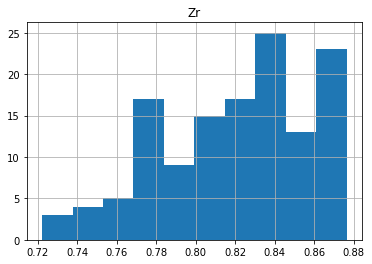

In [4]:
td = data[data['sample']=='PDAC_COM3_01255']
td.hist('Zr')

In [11]:
help(scatter_slices)

Help on function scatter_slices in module helpers.plotting:

scatter_slices(data, z, slice_axis, slice_starts, slice_widths, tern_axes, axes=None, ncols=2, figsize=None, colorbar=True, cmap=<matplotlib.colors.ListedColormap object at 0x0000013E0F702400>, vmin=None, vmax=None, titles=True, titlesize=14, titlebox_props={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5}, **slice_scatter_kw)



## Plot experimental data

Scale: 0.95
Scale: 0.85


Text(0.5,0.98,'$\\sigma_{elec}$')

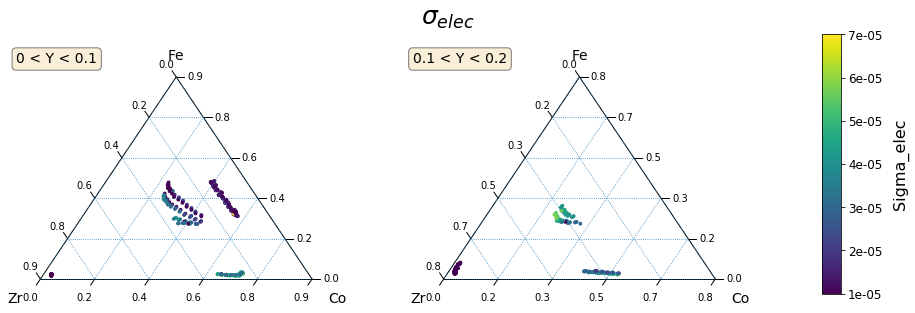

In [34]:
scatter_slices(data,'Sigma_elec','Y',[0,0.1],slice_widths=0.1,tern_axes = ['Co','Fe','Zr'],
               vmin=1e-5,vmax=7e-5,cb_kwargs={'tickformat':'%.0e'})
plt.subplots_adjust(top=0.8)
plt.suptitle(r'$\sigma_{elec}$',size=25)

Scale: 0.95
Scale: 0.85


Text(0.5,0.98,'log($\\sigma_{elec}$)')

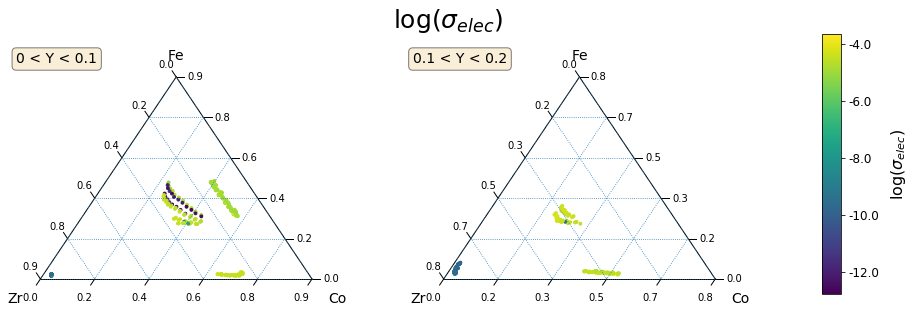

In [54]:
fig, axes = plt.subplots(1,2,figsize=(13,4.8))
scatter_slices(data,'log_sigma','Y',[0,0.1],slice_widths=0.1,tern_axes = ['Co','Fe','Zr'],axes=axes,
               cb_kwargs={'label':'$\log{(\sigma_{elec})}$'})
plt.subplots_adjust(top=0.8)
plt.suptitle(r'log($\sigma_{elec}$)',size=25)

In [38]:
(1 - (slice_val+slice_width)/2)/5

0.19

Scale: 0.965
Scale: 0.895
Scale: 0.825


Text(0.5,0.98,'Measured log($\\sigma_{elec}$), Y slices')

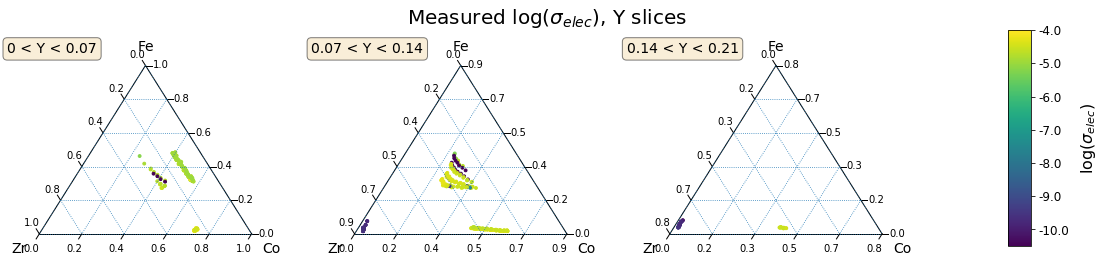

In [58]:
fig, axes = plt.subplots(1,3,figsize=(16,4))
scatter_slices(data,'log_sigma','Y',[0,0.07,0.14],slice_widths=0.07,tern_axes = ['Co','Fe','Zr'],axes=axes,
               vmin = -10.5, vmax=-4, cb_kwargs={'label':'$\log{(\sigma_{elec})}$'},ncols=3)
plt.subplots_adjust(top=0.8)
plt.suptitle(r'Measured log($\sigma_{elec}$), Y slices',size=20)

Scale: 0.85
Scale: 0.7
Scale: 0.1499999999999999


Text(0.5,0.98,'Measured log($\\sigma_{elec}$), Zr slices')

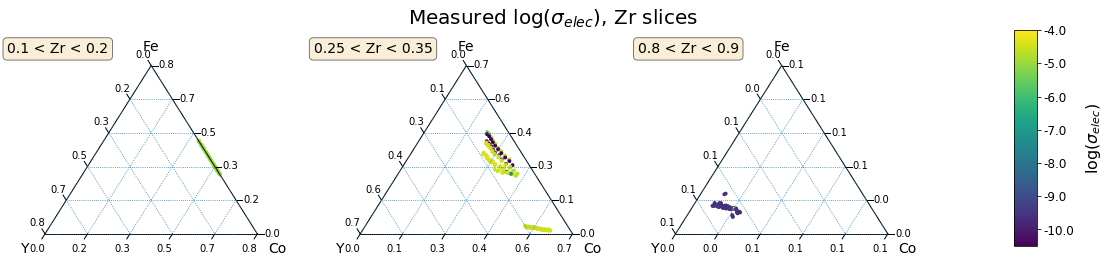

In [59]:
fig, axes = plt.subplots(1,3,figsize=(16,4))
scatter_slices(data,'log_sigma','Zr',[0.1,0.25,0.8],slice_widths=0.1,tern_axes = ['Co','Fe','Y'],axes=axes,
               vmin = -10.5, vmax=-4, cb_kwargs={'label':'$\log{(\sigma_{elec})}$'},ncols=3)
plt.subplots_adjust(top=0.8)
plt.suptitle(r'Measured log($\sigma_{elec}$), Zr slices',size=20)

Scale: 0.75
Scale: 0.65


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000013E1E382710>,
      dtype=object)

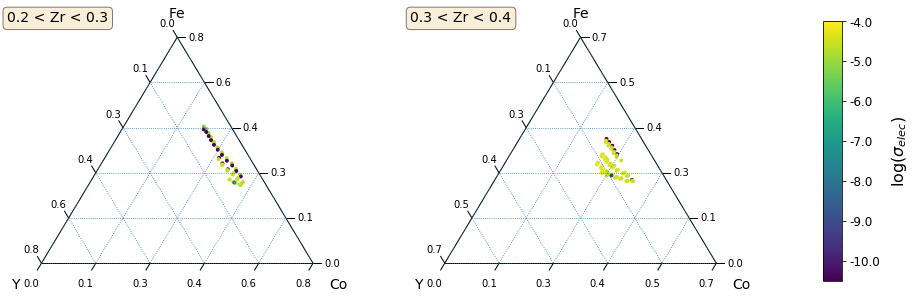

In [61]:
tdata = data.loc[data['sample']=='PDAC_COM3_01254',:]
fig, axes = plt.subplots(1,2,figsize=(13,4.8))
scatter_slices(tdata,'log_sigma','Zr',[0.2,0.3],slice_widths=0.1,tern_axes = ['Co','Fe','Y'],axes=axes,
               vmin = -10.5, vmax=-4, cb_kwargs={'label':'$\log{(\sigma_{elec})}$'},ncols=3)

Text(0,0.5,'Frequency')

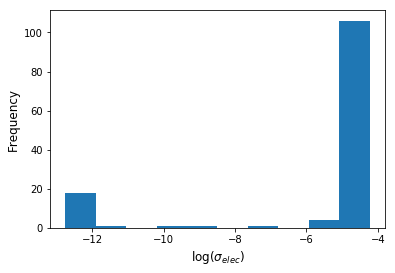

In [62]:
plt.hist(tdata['log_sigma'])
plt.xlabel('log($\sigma_{elec}$)',size=12)
plt.ylabel('Frequency',size=12)

## Plot Citrination predictions

In [78]:
#load features from pickles
pkldir = '../pickles'
os.listdir(pkldir)
cf_Co24Fe24 = pickle_dict(os.path.join(pkldir,'feat_Co24Fe24'))
cf_Co23Fe34 = pickle_dict(os.path.join(pkldir,'feat_Co23Fe34'))
cf_Co34Fe23 = pickle_dict(os.path.join(pkldir,'feat_Co34Fe23'))

In [79]:
Co24Fe24 = heatmap_inputs(cat_ox_lims={},tuple_scale=20, pkl_dict=cf_Co24Fe24, slice_axis='Y', slice_vals=[0,0.05,0.1],
                tern_axes=['Co','Fe','Zr'],conditions={'Atmosphere':'dry','Temperature ($^\circ$C)':473},Ba = 0.9)
Co23Fe34 = heatmap_inputs(cat_ox_lims={},tuple_scale=20, pkl_dict=cf_Co23Fe34, slice_axis='Y', slice_vals=[0,0.05,0.1],
                tern_axes=['Co','Fe','Zr'],conditions={'Atmosphere':'dry','Temperature ($^\circ$C)':473},Ba = 0.9)
Co34Fe23 = heatmap_inputs(cat_ox_lims={},tuple_scale=20, pkl_dict=cf_Co34Fe23, slice_axis='Y', slice_vals=[0,0.05,0.1],
                tern_axes=['Co','Fe','Zr'],conditions={'Atmosphere':'dry','Temperature ($^\circ$C)':473},Ba = 0.9)

In [95]:
#test/wake up views
test_inp = list(Co23Fe34.values())[0]
client.predict('5002',test_inp)

#client.predict('5014',test_inp)

In [96]:
client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')

#results_4999 = client.predict('4999',list(Co23Fe34.values())) #all samples, Co[2,3]Fe[3,4]
results_5002 = client.predict('5002',list(Co23Fe34.values())) #excluding 01255
#results_5014 = client.predict('5014',list(Co24Fe24.values())) #all samples, Co[2,4]Fe[2,4]

#sigma_4999 = [res.get_value('Property $\\sigma_{elec}$').value for res in results_4999]
sigma_5002 = [res.get_value('Property $\\sigma_{elec}$').value for res in results_5002]
#sigma_5014 = [res.get_value('Property $\\sigma_{elec}$').value for res in results_5014]
#sigma_4999_dict = dict(zip(inputs.keys(),sigma_4999))
sigma_5002_dict = dict(zip(Co23Fe34.keys(),sigma_5002))
#sigma_5014_dict = dict(zip(inputs.keys(),sigma_5014))
    

In [76]:
help(quat_slice_heatmap2)

Help on function quat_slice_heatmap2 in module helpers.plotting:

quat_slice_heatmap2(tuple_scale, zfunc, slice_val, zfunc_kwargs={}, style='triangular', slice_axis='Y', tern_axes=['Co', 'Fe', 'Zr'], labelsize=14, add_labeloffset=0, cmap=<matplotlib.colors.ListedColormap object at 0x0000013E0F702400>, ax=None, figsize=None, vmin=None, vmax=None, Ba=1, multiple=0.1, tick_kwargs={'tick_formats': '%.1f', 'offset': 0.02})
    get zvals from formula instead of tup



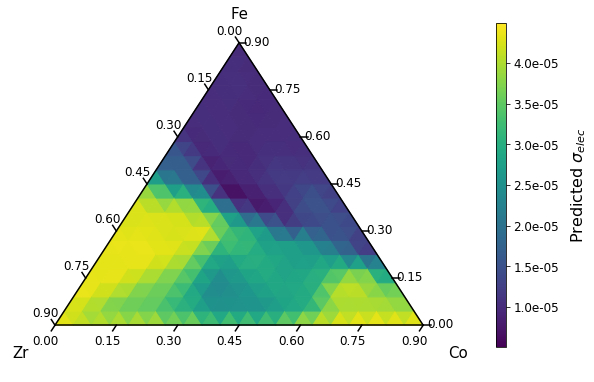

In [106]:
tax,vmin, vmax = quat_slice_heatmap2(tuple_scale=20,zfunc=dict_lookup,slice_val=0.1,zfunc_kwargs={'kdict':sigma_5002_dict},
                                    slice_axis='Y',tern_axes=['Co','Fe','Zr'], figsize=(7.5,6), labelsize=15, multiple=0.15,
                                     tick_kwargs={'tick_formats': '%.2f', 'offset': 0.02,'fontsize':12},Ba=0.9)
add_colorbar(vmin=vmin,vmax=vmax,label='Predicted $\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1e')